# View CPT Results

In [136]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (20, 7)

In [137]:
# load results
import glob
import os
import re

results_dir = '/home/jvdzwaan/data/tmp/dilipad/gov_opp/results/'

# document topic matrix (theta)
theta = pd.read_csv(os.path.join(results_dir, 'document-topic.csv'), index_col=0)

# phi topic (transposed)
phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics.csv'), index_col=0, encoding='utf-8')

# phi opinion (transposed) per perspective
opinion_files = glob.glob('{}opinions_*.csv'.format(results_dir))
phis_opinion_t = {}
for f in opinion_files:
    m = re.match(r'.+opinions_(.+).csv', f)
    phis_opinion_t[m.group(1)] = pd.read_csv(f, index_col=0, encoding='utf-8')

## 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

However, because in our case one document consists of the minutes of a single meeting, we might see multiple topics per document. To improve this, we might reconsider making a dataset with a document per ``pm:topic`` instead of a document per document.

In [138]:
a = theta.copy().apply(max, axis=1)
a.sort(ascending=False)

print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
print 'Median weight of most important topic: ', a.median()

Mean weight of most important topic: 0.39497328915 (std: 0.123577765915)
Min and max of most important topic: min: 0.142112068966, max: 0.668789808917
Median weight of most important topic:  0.405352622061


Line graph of the sorted topic weigths:

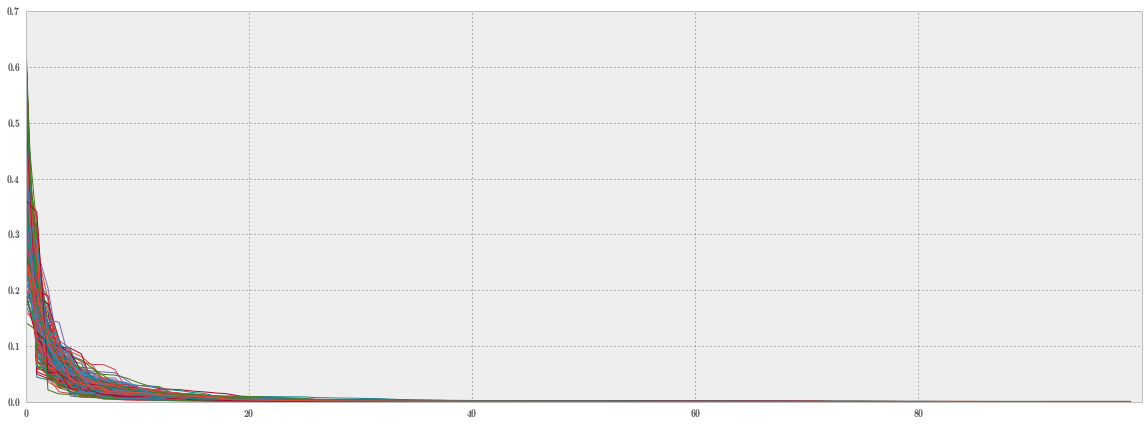

In [139]:
theta.copy().apply(lambda row:sorted(row)[::-1], axis=1).transpose().plot(legend=None);

## Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

2      2
3     18
4     48
5     64
6     51
7     11
8      7
10     2
dtype: int64


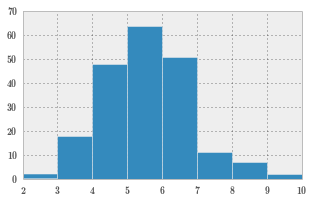

In [179]:
threshold = 0.05

topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
print topic_counts.value_counts(sort=False)
topic_counts.hist(bins=8, figsize=(5,3));

## Topics

In [141]:
def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['words_topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['words_opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

show_topic('70')

,words_topic_70,weights_topic_70,words_opinion_70_Opposition,weights_opinion_70_Opposition,words_opinion_70_Government,weights_opinion_70_Government
0,arts,0.076500,oud,0.092108,beoordelen,0.044308
1,dood,0.056024,helpen,0.040666,lijden,0.032626
2,euthanasiewet,0.053115,sterven,0.025150,medisch,0.023150
3,wens,0.045741,maatschappelijk,0.019990,helpen,0.019734
4,hulp,0.044371,stappen,0.016783,ondraaglijk,0.017835
5,zelfbeschikking,0.032764,ondraaglijk,0.013924,uitzichtloos,0.017432
6,doodswens,0.026303,principieel,0.013174,actief,0.016737
7,patiënt,0.019454,medisch,0.012884,bekijken,0.016626
8,aandacht,0.018441,vrij,0.012484,sterven,0.016037
9,standpunt,0.017693,terecht,0.011959,oprecht,0.013470
